# #DataMadness

**Team:**

Arthur Haas  
Kata Keresztesi

**remarks: How to use this notebook:**

1. Download dataset from kaggle: https://www.kaggle.com/datasnaek/youtube-new/data
2. Unzip next to this jupyter notebook and name folder "data"

Your files inside this folder should be:

```
.
..
|-- THIS_NOTEBOOK.ipynb
|-- data
  |-- *.csv
  |-- *.json
```

---
# story of this notebook:
- [Task: Analyse youtube trending videos and create a video](#Task%3A-Analyse-YouTube-trending-videos-and-create-a-video)
- [I. Import of YouTube data](#I.-Import-of-YouTube-data)
- [II. First look at the data and data cleaning](#II.-First-look-at-the-data-and-data-cleaning)
- [III. Anwering questions from assignment](#III.-Anwering-questions-from-assignment)
	- [Q1: How did the consumption of youtube videos by country change over time?](#Q1%3A-How-did-the-consumption-of-youtube-videos-by-country-change-over-time%3F)
	- [Q2: For which category do you have the highest likelihood of succeeding depending on the country you are in?](#Q2%3A-For-which-category-do-you-have-the-highest-likelihood-of-succeeding-depending-on-the-country-you-are-in%3F)
	- [Q3: Should we prefer longer or shorter titles for as many views as possible?](#Q3%3A-Should-we-prefer-longer-or-shorter-titles-for-as-many-views-as-possible%3F)
	- [Q4: Wordcloud](#Q4%3A-Wordcloud)
	- [Q5: Clickbaitiness](#Q5%3A-Clickbaitiness)
- [IV. Conclusions](#IV.-Conclusions)
---

# Task: Analyse YouTube trending videos and create a video

**Dataset:**

Our dataset contains around 12 years of trending youtube video data for 10 countries.
source: https://www.kaggle.com/datasnaek/youtube-new
We might build the following story:

We are social media strategy advisors focusing on video creation on youtube.
Title: How to make your perfect youtube video?

**Questions:**

- For which category do you have the highest likelihood of succeeding depending on the country you are in?
- How did the consumption of youtube videos by country change over time?
- What are the factors for a video becoming popular? Let's be more specific:
	- Should we prefer longer or shorter titles for as many views as possible?
	- How to use the title, tags and description for as many likes as possible?
	- *As a nice-to-have, we will look at whether clickbait still works? Text mining. Trying this out, we hope it will work ;)*

**imports**

In [1]:
# core
import os
import re
import json
import datetime

# data and visuals
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.core.display

# modeling
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import warnings
warnings.filterwarnings('ignore')

# config
def apply_styles():
    matplotlib.rcParams['font.size'] = 12
    matplotlib.rcParams['figure.figsize'] = (18, 6)
    matplotlib.rcParams['lines.linewidth'] = 1
    pd.set_option('display.max_rows', 50)
    pd.set_option('display.max_columns', 50)
    pd.set_option('display.width', 500)
    pd.set_option('display.max_colwidth', 100)

apply_styles()

**set design for graphs to fit our video theme**

In [2]:
#sns.set(style="ticks")
sns.set_style("darkgrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})

In [3]:
COLOR_PALETTE = {}
COLOR_PALETTE['main'] = '#3b3c3a'
COLOR_PALETTE['highlight_primary'] = '#f5bf23'
COLOR_PALETTE['highlight_secondary'] = '#2ca2d7'
COLOR_PALETTE['background'] = '#E5E8E8'

---
# I. Import of YouTube data

This section deals with importing and cleaning the data. In general, the data is distributed among multiple files and thus has to be concatinated through all files first.

## Configuration

In [4]:
# path to the dataset folder
DATASETS_PATH = "data"

# set countries you want to import (details about abbreviation on kaggle page)
# available options include: ['IN', 'FR', 'GB', 'CA', 'US', 'DE']
# we do not support these countries:
#   RU, JP, KR, MX: due to encoding issues and us prioritizing on the other countries
#   IN: due to a language we don't understand; some corrupt values for video_id being "#NAME?"
COUNTRIES = ['FR', 'GB', 'CA', 'US', 'DE']


# Further constant variables
FILESNAME_SUFFIX_CATEGORIES = "_category_id.json"
FILESNAME_SUFFIX_VIDEOS = "videos.csv"

## Helping functions

In [5]:
def import_country(country):
    """
    Imports dataset for specific country
    """
    filepath = os.path.join(DATASETS_PATH, country + FILESNAME_SUFFIX_VIDEOS)
    df = pd.read_csv(filepath, encoding='utf-8')
    
    # add further columns
    df['country'] = country  

    # dropping duplicates based upon primary key, as these exist
    # Analysis has shown, that GB and US have up to 3 equal primary_keys but slightly different data
    # We suppose, this comes from incorrect data gathering when creating this data set.
    df.drop_duplicates(inplace=True)
    df.drop_duplicates(subset=['video_id', 'trending_date'], inplace=True)
    
    return df

In [6]:
def check_data(countries):
    print(f"Start checking data for countries {countries}")
    cols = ['video_id',
     'trending_date',
     'title',
     'channel_title',
     'category_id',
     'publish_time',
     'tags',
     'views',
     'likes',
     'dislikes',
     'comment_count',
     'thumbnail_link',
     'comments_disabled',
     'ratings_disabled',
     'video_error_or_removed',
     'description',
     'country']


    all_data = []
    for country in countries:
        all_data.append(import_country(country))

    for df in all_data:
        assert(df.shape[1] == 17)

    print("checking columns")
    for df in all_data:
        assert((list(df.columns) == cols) == True)


    print("checking dtypes")
    dtypes = []
    for df in all_data:
        dtypes.append(df.dtypes)

    i = 0
    for i in range(1, len(dtypes)):
        assert((list(dtypes[i-1]) == list(dtypes[i])) == True)

    return True

In [7]:
def import_data(countries):
    """
    Divides metric data from textual data. Latter one is hard to analyse and must be preprocessed first.
    Goal: Deviding tasks and working in parallel.
    """

    # checking if data is correct
    # not very efficient, but therefor you can comment this out, if necessary
    check_data(countries)
    
    dataframes = []
    for country in countries:
        print(f"importing {country}")
        df_sub = import_country(country)   
        dataframes.append(df_sub)

    # concatinating all files from above folder
    return pd.concat(dataframes).reset_index(drop=True)

In [8]:
df = import_data(COUNTRIES)

Start checking data for countries ['FR', 'GB', 'CA', 'US', 'DE']
checking columns
checking dtypes
importing FR
importing GB
importing CA
importing US
importing DE


### add category title to dataset

In [9]:
df['category'] = np.nan
category_col_index = df.columns.get_loc("category")

In [10]:
for country in COUNTRIES:
    print(f"Add category title to data of country: {country}")
    
    with open(f'data/{country}_category_id.json') as file:
        content = file.read()
        cat = json.loads(content)
    
    for item in cat['items']:
        indicies_to_set = df[(df.country == country) & (df.category_id == int(item['id']))].index
        df.category.iloc[indicies_to_set] = item['snippet']['title']

Add category title to data of country: FR
Add category title to data of country: GB
Add category title to data of country: CA
Add category title to data of country: US
Add category title to data of country: DE


In [11]:
# check nan in category
print(f"{df.category.isna().sum()} rows do not have a category assigned.")
print(f"{df[df.category.fillna('').str.contains('Other')].shape[0]} rows use other as a category name")

534 rows do not have a category assigned.
0 rows use other as a category name


After inserting the category title from the .json files into our dataset, we still have 534 rows without an assigned category, although there is no missing value inside category_id column. Furthermore, a short check has shown, that the affacted category ids are missing inside the json files. Hence, we are going to fill missing values using "other" as a category.

In [12]:
df.category.fillna('Other', inplace=True)
df.drop(columns=['category_id'], inplace=True)

---
# II. First look at the data and data cleaning

In [13]:
df.shape

(202086, 17)

In [14]:
df.nunique()

video_id                   79408
trending_date                205
title                      79736
channel_title              16659
publish_time               72941
tags                       66247
views                     153768
likes                      63445
dislikes                   14883
comment_count              22710
thumbnail_link             79389
comments_disabled              2
ratings_disabled               2
video_error_or_removed         2
description                69866
country                        5
category                      19
dtype: int64

In [15]:
pd.DataFrame(dict(dtype = df.dtypes, contains_nan = df.isna().any())).reset_index().rename({'index': 'column'}, axis=1)

,column,dtype,contains_nan
0,video_id,object,False
1,trending_date,object,False
2,title,object,False
3,channel_title,object,False
4,publish_time,object,False
5,tags,object,False
6,views,int64,False
7,likes,int64,False
8,dislikes,int64,False
9,comment_count,int64,False


### date columns

One date and one timestamp column exist. Both need to be correctly read.

In [16]:
df[['trending_date', 'publish_time']].head(1)

,trending_date,publish_time
0,17.14.11,2017-11-13T17:32:55.000Z


In [17]:
# parse both date columns to pd.datetime
df.trending_date = pd.to_datetime(df.trending_date, format='%y.%d.%m')
df.publish_time = pd.to_datetime(df.publish_time)

In [18]:
df['trending_date,publish_time'.split(',')].dtypes

trending_date         datetime64[ns]
publish_time     datetime64[ns, UTC]
dtype: object

### numerical columns

This dataset shows a video, identified by its video_id, for every date it was a trending video. Thus, we see repeating videos in the data and have to handle this: All four numerical columns show a snapshot of their value at the specific date, i.e. these are cumulative numbers and have to be recalculated for each day.

In [19]:
df[df.video_id == '_I_D_8Z4sJE'].sort_values(by='trending_date')[['video_id', 'trending_date', 'views']].head(10)

,video_id,trending_date,views
21196,_I_D_8Z4sJE,2018-03-02,359405
182476,_I_D_8Z4sJE,2018-03-02,359405
100664,_I_D_8Z4sJE,2018-03-02,359405
21357,_I_D_8Z4sJE,2018-03-03,30686233
62096,_I_D_8Z4sJE,2018-03-03,30686233
182618,_I_D_8Z4sJE,2018-03-03,30686233
100818,_I_D_8Z4sJE,2018-03-03,30686233
21596,_I_D_8Z4sJE,2018-03-04,40567774
62296,_I_D_8Z4sJE,2018-03-04,40567774
101019,_I_D_8Z4sJE,2018-03-04,40567774


In [20]:
df.describe()

,views,likes,dislikes,comment_count
count,2.020860e+05,2.020860e+05,2.020860e+05,2.020860e+05
mean,2.049672e+06,5.674223e+04,3.062416e+03,6.170041e+03
std,9.404964e+06,2.076083e+05,2.860673e+04,3.144489e+04
min,2.230000e+02,0.000000e+00,0.000000e+00,0.000000e+00
25%,7.500900e+04,1.444000e+03,6.700000e+01,2.090000e+02
50%,3.085165e+05,7.584000e+03,2.890000e+02,9.230000e+02
75%,1.100624e+06,3.218300e+04,1.150000e+03,3.515000e+03
max,4.245389e+08,5.613827e+06,1.944971e+06,1.626501e+06


### object columns

In [21]:
# fill missing descriptions with empty string
print(df.description.isna().sum())
df.description.fillna('', inplace=True)
print(df.description.isna().sum())

6937
0


### Handle cumulative columns

Idea: Usage of two different DataFrames:

- (a) original dataset: cumulative numerical data for every trending_date of the video
- (b) overview dataset: aggregated data to hold only one row per video_id per country.

We are going to achieve this, by splitting the original data into dynamical and static columns. After aggregating the dynamical data by using the max() function and dropping all duplicates in the static dataset, we are going to merge both. We use the max() function, because aggregating cumulative values by using max() leads to the final amount.

**dynamic data**

In [22]:
columns_with_dynamic_content = ['trending_date', 'views', 'likes', 'dislikes', 'comment_count']
df_dyn = df[['video_id', 'country'] + columns_with_dynamic_content].copy().reset_index(drop=True)
df_dyn.shape

(202086, 7)

In [23]:
df_dyn_agg = df_dyn.groupby(['video_id', 'country']).agg({
    'trending_date': ['min','max', 'count'],
    'views': 'max',
    'likes': 'max',
    'dislikes': 'max',
    'comment_count': 'max',
})
# concatinate name of column with its aggregation method name
df_dyn_agg.columns = ["_".join(x) for x in df_dyn_agg.columns.ravel()]

# but remove the aggregation method name in unnecessary cases
df_dyn_agg = df_dyn_agg.rename(columns=
               {'views_max':'views',
                'likes_max':'likes',
                'dislikes_max':'dislikes',
                'comment_count_max':'comment_count'
               })
df_dyn_agg = df_dyn_agg.reset_index()

In [24]:
df_dyn_agg.head()

,video_id,country,trending_date_min,trending_date_max,trending_date_count,views,likes,dislikes,comment_count
0,--2K8l6BWfw,FR,2018-03-06,2018-03-06,1,4822,694,4,34
1,--45ws7CEN0,CA,2018-06-12,2018-06-12,1,309197,3837,516,278
2,--728h8mnDY,FR,2017-12-06,2017-12-07,2,39535,2573,51,269
3,--7vNbh4UNA,CA,2018-04-14,2018-04-16,3,1335225,60694,1576,11732
4,--7vNbh4UNA,DE,2018-04-14,2018-04-14,1,1082647,52113,1284,10602


**static data**

In [25]:
columns_to_group = [col for col in list(df.columns) if col not in columns_with_dynamic_content]
df_fixed = df[columns_to_group].copy().reset_index(drop=True)
print(f"before {df_fixed.shape}")

# drop duplicates based on video_id and country being the primary key
df_fixed.drop_duplicates(subset=['video_id', 'country'], inplace=True)
df_fixed.reset_index(drop=True)
print(f"after {df_fixed.shape}")

before (202086, 12)
after (94258, 12)


**merge both datasets**

In [26]:
df_static = df_fixed.merge(df_dyn_agg, how='left', on=['video_id', 'country'])

In [27]:
df_static.head(1)

,video_id,title,channel_title,publish_time,tags,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,trending_date_min,trending_date_max,trending_date_count,views,likes,dislikes,comment_count
0,Ro6eob0LrCY,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,2017-11-13 17:32:55+00:00,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|""merde",https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidéo la plus réalistiquement haineuse du YouTube Game...,FR,Entertainment,2017-11-14,2017-11-17,4,602481,41538,2908,5321


## EDA

With two representations of the dataset:

In [28]:
df.shape

(202086, 17)

In [29]:
df_static.shape

(94258, 19)

This dataset shows the performance of trending videos on youtube equally distributed from the end of 2017 to mid 2018. The production of these videos ranges from 2006 to 2018. Canada and Great Britan show the most views, while France is last.

Appart from views, this dataset contains likes, dislikes and the count of comments per video, with likes being the column with the highest number.

A video can be trending on several days. This dataset contains videos, which are trending between a range of 1 to 38 days. But the majority of these videos don't even get 5 days in total.

By looking at the publishing time, we see, that most videos are uploaded during mid-day and the least during the night. But videos published in the morning hours are more likely to receive more views. This is especially true for Great Britan.

In [30]:
df.trending_date.agg(['min', 'max'])

min   2017-11-14
max   2018-06-14
Name: trending_date, dtype: datetime64[ns]

In [31]:
df.publish_time.agg(['min', 'max'])

min   2006-07-23 08:24:11+00:00
max   2018-06-14 02:25:38+00:00
Name: publish_time, dtype: datetime64[ns, UTC]

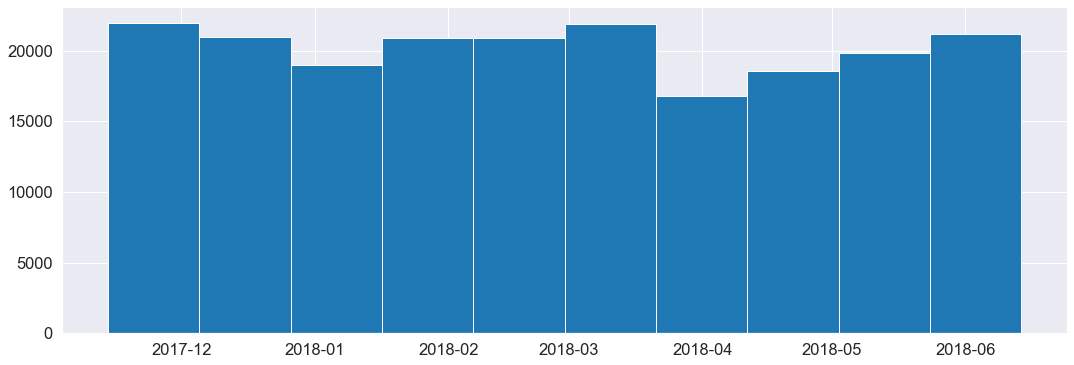

In [32]:
fig, ax = plt.subplots(figsize=(18,6))
df.trending_date.hist()

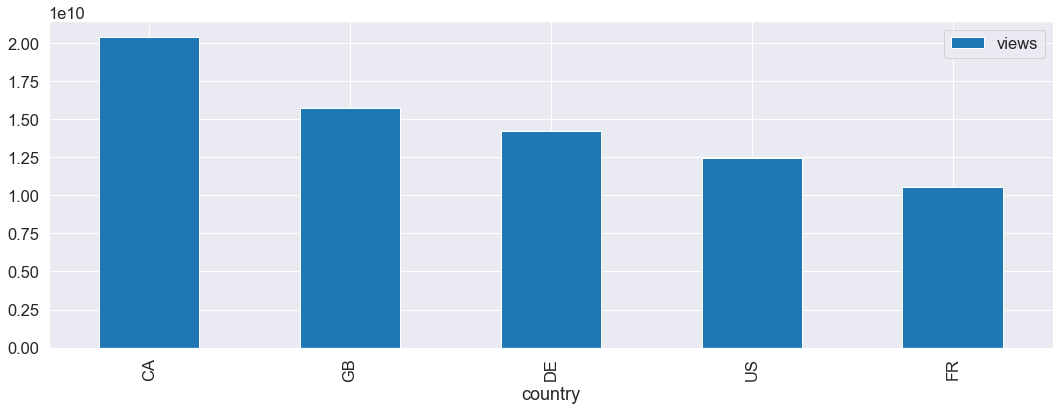

In [33]:
fig, ax = plt.subplots(figsize=(18,6))
df_static.groupby('country')[['views']].sum().sort_values(by='views', ascending=False).plot(kind='bar', ax=ax)

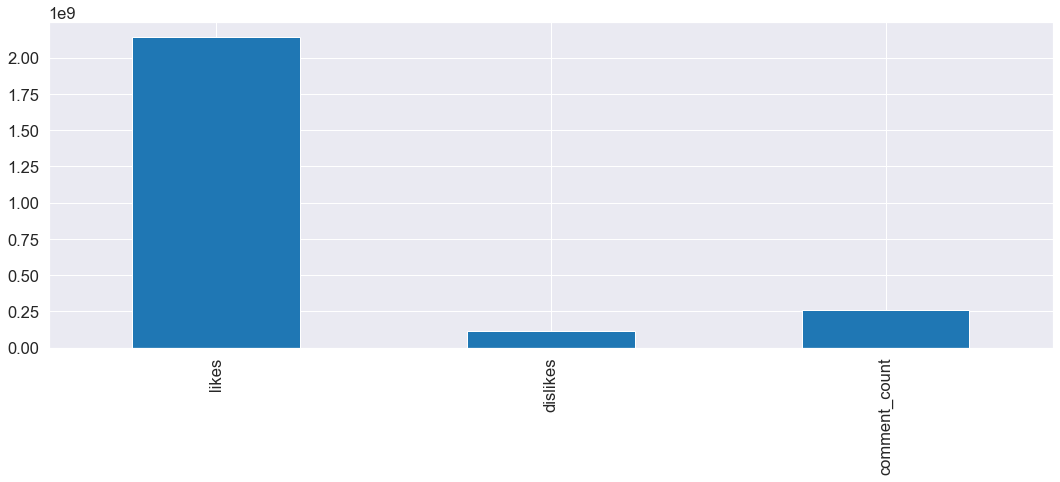

In [34]:
fig, ax = plt.subplots(figsize=(18,6))
df_static[['likes', 'dislikes', 'comment_count']].sum().plot(kind='bar', ax=ax)

min     1
max    38
Name: trending_date_count, dtype: int64


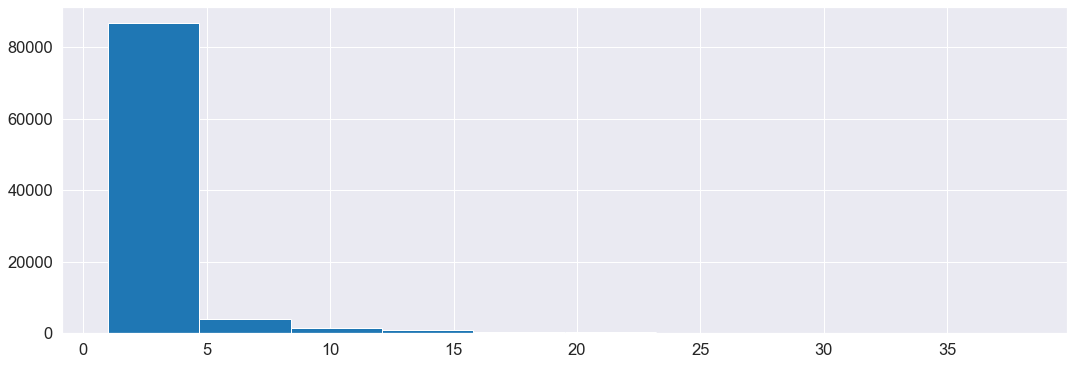

In [35]:
# number of days, that a video is trending
fig, ax = plt.subplots(figsize=(18,6))
print(df_static.trending_date_count.agg(['min', 'max']))
df_static.trending_date_count.hist()

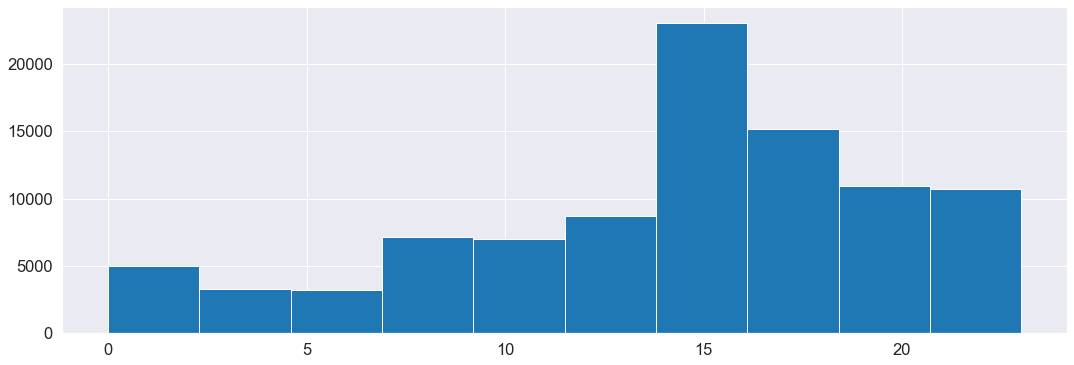

In [36]:
# hour of publishing a video, that is becoming trending
fig, ax = plt.subplots(figsize=(18,6))
df_static.publish_time.dt.hour.hist()

**Is is possible to use linear regression to predict likes based upon views?**

Not it is not. A r^2 score of 0.566 is not good enought.

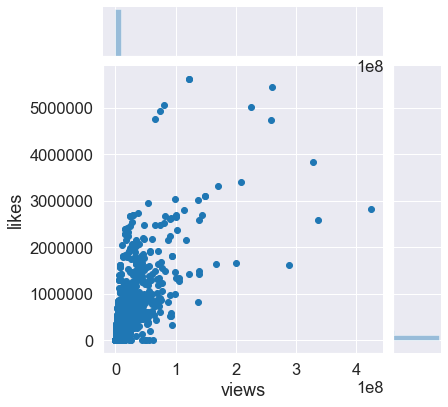

In [37]:
sns.jointplot(x='views', y='likes', data=df_static)

MAE (test): 17819
MSE (test): 4215877037
R2  (test): 0.612


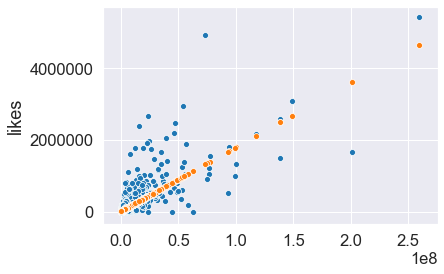

In [38]:
X = df_static.views.values.reshape(-1,1)
y = df_static.likes

itrain, itest = train_test_split(range(df_static.shape[0]), test_size=0.25, random_state=42)
X_train = X[itrain]
X_test = X[itest]
y_train = y[itrain]
y_test = y[itest]

linearReg = LinearRegression().fit(X_train, y_train)

mae = mean_absolute_error(y_test, linearReg.predict(X_test))
mse = mean_squared_error(y_test, linearReg.predict(X_test))
r2 = r2_score(y_test, linearReg.predict(X_test))

print("MAE (test): {:0.0f}".format(mae))
print("MSE (test): {:0.0f}".format(mse))
print("R2  (test): {:0.3f}".format(r2))

sns.scatterplot(x=X_test.ravel(), y=y_test)
ax =sns.scatterplot(x=X_test.ravel(), y=linearReg.predict(X_test))

**Does it matter at which time during the day a video is uploaded?**

Yes, it does. It's best to publish the video in the morning hours.

In [39]:
df_static['publish_time_hour'] = df_static.publish_time.dt.hour

In [40]:
df_q1_bonus = df_static.groupby(['country', 'publish_time_hour']).views.agg(['count', 'sum']).reset_index()
df_q1_bonus['avg_views'] = df_q1_bonus['sum'] / df_q1_bonus['count']
df_q1_bonus.head(1)

,country,publish_time_hour,count,sum,avg_views
0,CA,0,720,520361885,722724.840278


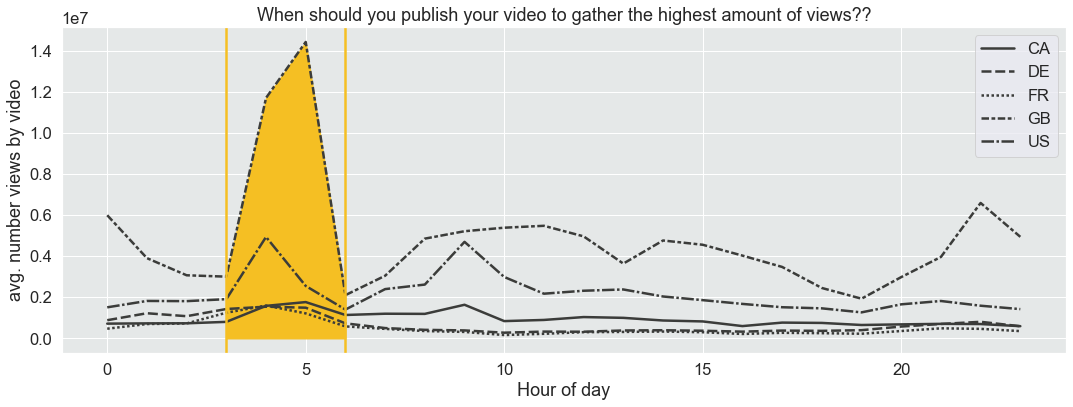

In [90]:
fig = plt.figure(figsize=(18,6))

clrs = [COLOR_PALETTE['main'] if (x < max(df_q1_bonus.avg_views)) else COLOR_PALETTE['highlight_primary'] for x in range(0,5)]

df_plot = df_q1_bonus.pivot(index='publish_time_hour', columns='country', values='avg_views').copy()
ax = sns.lineplot(data=df_plot, palette=clrs) 
for p, label in zip(ax.patches, df_q1_bonus.avg_views.values):
    ax.annotate(f"{int(round(label/1000,0))}k", (p.get_x() + 0.2, p.get_height()+2000))
kde_x, kde_y = ax.lines[3].get_data()

#plotting the two lines
x0=3
x1=6
p1 = plt.axvline(x=x0,color=COLOR_PALETTE['highlight_primary'])
p2 = plt.axvline(x=x1,color=COLOR_PALETTE['highlight_primary'])


ax.fill_between(kde_x, kde_y, where=(kde_x>=x0) & (kde_x<=x1) , 
                interpolate=True, color=COLOR_PALETTE['highlight_primary'])

ax.set_title('When should you publish your video to gather the highest amount of views??')
plt.xlabel('Hour of day')
plt.ylabel('avg. number views by video')



ax.set_facecolor(COLOR_PALETTE['background'])
fig.savefig('img/publish_hour_success.jpg')
fig.savefig('img/publish_hour_success.png', transparent=True)

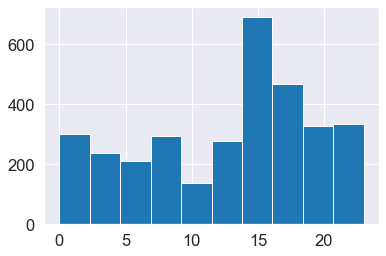

In [74]:
# GB publishing times
df_static[df_static.country == 'GB'].publish_time_hour.hist()

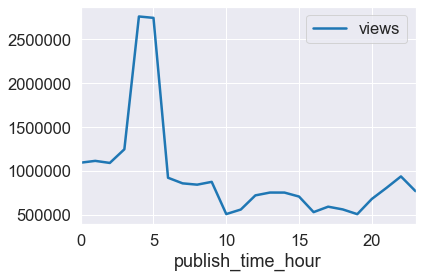

In [87]:
# checking, this peak again, but differently
df_static.groupby('publish_time_hour')[['views']].mean().plot()

In [79]:
# select videos from the hour 4 and 5 to check for similarities
# Hypothesis: Music videos have the highest views. Do more music videos get published during this time?
df_static[(df_static.country == 'GB') & (df_static.publish_time_hour.isin([4,5]))].sort_values(by='views', ascending=False).head(3)

,video_id,title,channel_title,publish_time,tags,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,trending_date_min,trending_date_max,trending_date_count,views,likes,dislikes,comment_count,publish_time_hour,title_length,title_tokens,title_contains_channel_title,channel_title_length,tags_tokens,desc_length,desc_tokens,clickbaitiness_score
32803,_I_D_8Z4sJE,Nicky Jam x J. Balvin - X (EQUIS) | Video Oficial,NickyJamTV,2018-03-02 05:00:19+00:00,"Bad Bunny|""Amorfoda""|""Dura""|""Daddy Yankee""|""Ozuna""|""Romeo Santos""|""El Farsante Remix""|""Drake""|""G...",https://i.ytimg.com/vi/_I_D_8Z4sJE/default.jpg,False,False,False,Disponible en tu plataforma preferida:\nhttps://goo.gl/b8TDFS \n\nNicky Jam y J. Balvin performi...,GB,Music,2018-03-03,2018-04-07,36,424538912,2818771,149275,99380,5,49,11,False,10,33,1429,228,NaN
33476,VYOjWnS4cMY,Childish Gambino - This Is America (Official Video),ChildishGambinoVEVO,2018-05-06 04:00:07+00:00,"Childish Gambino|""Rap""|""This Is America""|""mcDJ Recording/RCA Records""",https://i.ytimg.com/vi/VYOjWnS4cMY/default.jpg,False,False,False,“This is America” by Childish Gambino http://smarturl.it/TcIgADirector: Hiro MuraiProducer: Doom...,GB,Music,2018-05-07,2018-06-11,35,259721696,5444541,379862,553371,4,51,8,False,19,4,213,26,NaN
32682,xpVfcZ0ZcFM,Drake - God’s Plan,DrakeVEVO,2018-02-17 05:00:01+00:00,"Drake new music|""Drake Gods Plan""|""Drake God’s Plan""|""Scary Hours""|""Drake Charity Giveaway""|""Dra...",https://i.ytimg.com/vi/xpVfcZ0ZcFM/default.jpg,False,False,False,God’s Plan (Official Video)\n\nSong Available Here: https://Drake.lnk.to/ScaryHoursYD\n\n \n\nDi...,GB,Music,2018-02-22,2018-03-25,32,258164991,4737873,117198,301756,5,18,4,False,9,6,346,37,NaN


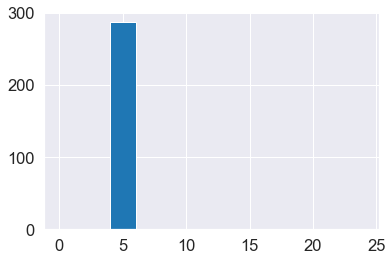

In [85]:
# yes, the hypthesis was correct. All music videos trending in GB where published in the morning
df_static[(df_static.country == 'GB') & (df_static.publish_time_hour.isin([4,5]))].publish_time_hour.hist(bins=12, range=(0, 24))

# III. Anwering questions from assignment

## Q1: How did the consumption of youtube videos by country change over time?

While the dataset contains data from 12 years, it is not usable to answer this questions. Reason being, that we have only 6 month of data for trending youtube videos, and just the publishing date of some of these videos reaches back to 2006. Thus we have analysed the data a furhter and are going to modify this questions to tell a slightly differnt story:

"Don't worry, dear customer, if you won't be able to make your video a trending one. Our research shows, that even a 12 year old video from 2006 is able to get its spot among trending videos in 2018. If you curious what it was, here are 3 seconds from that video: https://www.youtube.com/watch?v=JJmqCKtJnxM&feature=youtu.be&t=26" Title: Budweiser - Original Whazzup? ad

bottom line: Still trending in 2018, an advertisment from 12 years ago. So, never give up on social media.

*remark: The trending date of this video was 2018-02-05, one day after the US super bowl. This shows, that there was a very good reason, why this video became popular.*

In [42]:
df.trending_date.agg(['min', 'max'])

min   2017-11-14
max   2018-06-14
Name: trending_date, dtype: datetime64[ns]

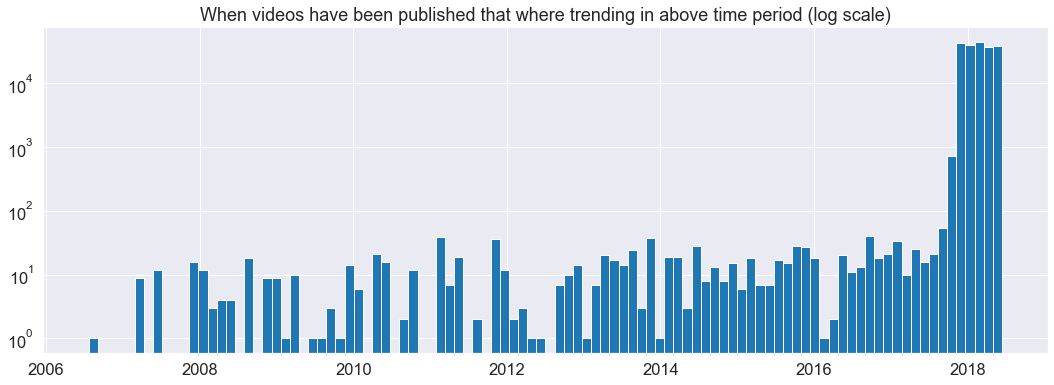

In [43]:
fig, ax = plt.subplots(figsize=(18,6))
df.publish_time.hist(ax=ax, bins=100, bottom=0)
ax.set_yscale('log')
tmp = ax.set_title("When videos have been published that where trending in above time period (log scale)")

In [44]:
df[df.publish_time.dt.year == 2006]

,video_id,trending_date,title,channel_title,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category
136641,MJO3FmmFuh4,2018-02-05,Budweiser - Original Whazzup? ad,dannotv,2006-07-23 08:24:11+00:00,"Budweiser|""Bud""|""Whazzup""|""ad""",258506,459,152,82,https://i.ytimg.com/vi/MJO3FmmFuh4/default.jpg,False,False,False,"Original Whazzup ad - however, there is a little *glitch* in the middle...sorry.",US,Entertainment


## Q2: For which category do you have the highest likelihood of succeeding depending on the country you are in?

Top categories by views are mostly similar across all countries. The top two ones are either music or entertainment. We have decided to look past these two popular categories, to identify a difference:

- The views as share by country for music range from 70% (GB) to 20% (DE)
- The views as share by country for entertainment around 20-30%

Putting these aside, we see favorites for countries:
 
- France -> sports
- Germany -> people & blogs
- Canada -> comedy

In [45]:
# create a new dataframe based upon grouping by country and category
df_q2 = df_static.groupby(['country', 'category'])[['views']].sum().reset_index()

# we want to create a new column, which holds the view sum over countries
df_q2['country_views'] = df_q2.groupby('country').views.transform(sum)

# Calculating the share a category has based upon views per country
df_q2['view_share_of_country'] = round((df_q2.views / df_q2.country_views) * 100,2)

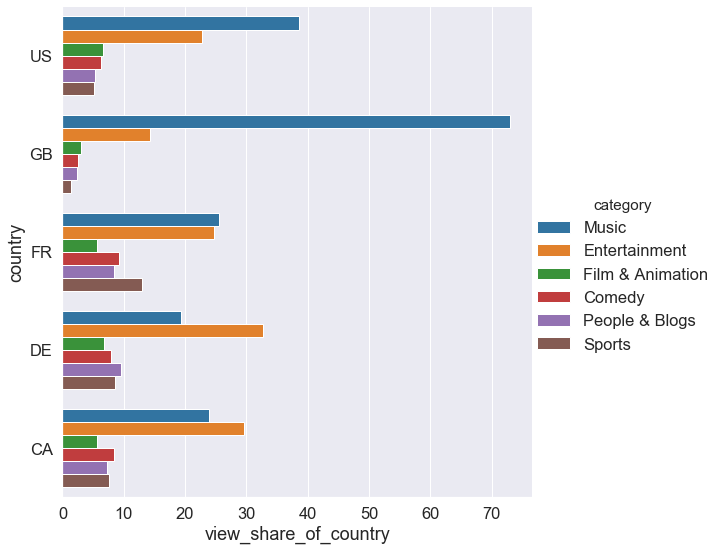

In [46]:
data_to_plot = df_q2.sort_values(by=['country','views'], ascending=False).groupby('country')[['country', 'category', 'view_share_of_country']].head(6)
sns.catplot(x='view_share_of_country', y='country', hue='category',
            data=data_to_plot,
            kind='bar',
            height=8, # make the plot 5 units high
            aspect=1) # height should be three times width)

In [47]:
print("Top 3 categories by country and their view share of this country")
df_q2.sort_values(by=['country', 'views'], ascending=False).groupby('country')[['country', 'category', 'view_share_of_country']].head(3)


Top 3 categories by country and their view share of this country


,country,category,view_share_of_country
75,US,Music,38.65
71,US,Entertainment,22.68
72,US,Film & Animation,6.60
60,GB,Music,72.96
56,GB,Entertainment,14.22
57,GB,Film & Animation,3.08
43,FR,Music,25.58
38,FR,Entertainment,24.72
50,FR,Sports,12.98
20,DE,Entertainment,32.77


## Q3: Should we prefer longer or shorter titles for as many views as possible?

To answer this questions, we have created several new metrics from the textual columns, e.g. by counting the characters or words. For the graph below, we have grouped the title length into bins of 10 characters and plotted it against the views. As a result we see, that it's better to use titles with about 20 characters in length.

In [48]:
# First, adding more columns to help answer this question:

# title
df_static['title_length'] = df_static.title.apply(lambda x: len(x))
df_static['title_tokens'] = df_static.title.apply(lambda x: len(x.split(' ')))
df_static['title_contains_channel_title'] = df_static.apply(lambda row: (row['channel_title'].lower().replace(' ','') in row['title'].lower().replace(' ','')), axis=1)

# channel
df_static['channel_title_length'] = df_static.channel_title.apply(lambda x: len(x))

# tags
df_static['tags_tokens'] = df_static.tags.apply(lambda x: len(x.split('|')))

# description
df_static['desc_length'] = df_static.description.apply(lambda x: len(x))
df_static['desc_tokens'] = df_static.description.apply(lambda x: len(x.split(' ')))

In [49]:
# creating dataset to plot
df_q3 = df_static.groupby(['title_length']).views.agg(['sum', 'count']).reset_index()

# nice trick: https://stackoverflow.com/questions/26454649/python-round-up-to-the-nearest-ten
df_q3['length_group'] = (df_q3.title_length + 9) // 10 * 10
df_q3 = df_q3.groupby('length_group').agg({'sum':'sum', 'count':'sum'})
df_q3['avg_views'] = df_q3['sum'] / df_q3['count']
df_q3.reset_index(inplace=True)
df_q3.head()

,length_group,sum,count,avg_views
0,10,242213267,252,9.611638e+05
1,20,3978616887,3246,1.225698e+06
2,30,8538810162,8740,9.769806e+05
3,40,14770882905,14634,1.009354e+06
4,50,12928326212,17269,7.486436e+05


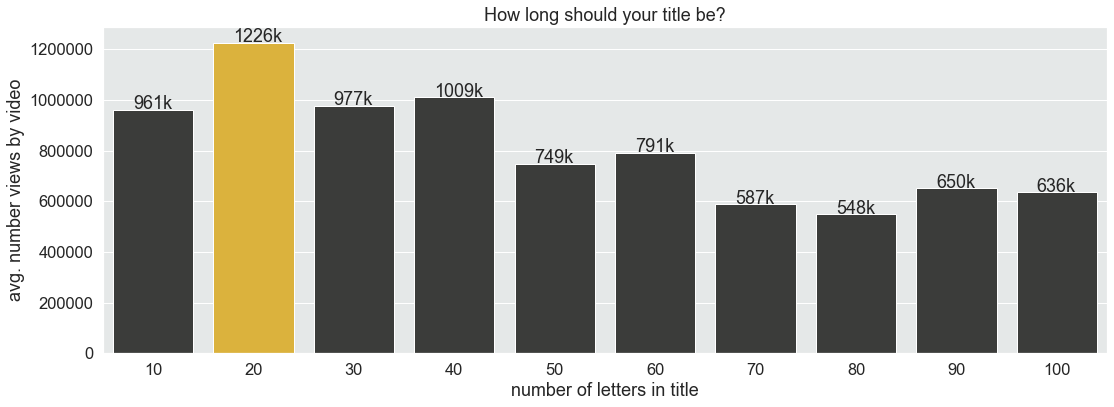

In [50]:
fig = plt.figure(figsize=(18,6))

# use custom color palette based upon own color theme
clrs = [COLOR_PALETTE['main'] if (x < max(df_q3.avg_views)) else COLOR_PALETTE['highlight_primary'] for x in  df_q3.avg_views]
ax = sns.barplot(x='length_group', y='avg_views', data=df_q3, palette=clrs)

# add annotations
for p, label in zip(ax.patches, df_q3.avg_views.values):
    ax.annotate(f"{int(round(label/1000,0))}k", (p.get_x() + 0.2, p.get_height()+2000))

# set elements of graph 
ax.set_title('How long should your title be?')
plt.xlabel('number of letters in title')
plt.ylabel('avg. number views by video')

# export it
ax.set_facecolor(COLOR_PALETTE['background'])
fig.savefig('img/title_length.jpg')
fig.savefig('img/title_length.png', transparent=True)

## Q4: Wordcloud

To generate this wordcloud, we have performed two steps:

1. Make all tags accessable individually and map their video's performance (views, likes, ...) to it. This is later used to color code the word cloud by a measurement of goodness.
2. Create a word cloud using following github repository: https://github.com/amueller/word_cloud/tree/master

Most frequently used tags are: donald trump, talk show, funny video, Late Show, Real Madrid

In [51]:
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [52]:
# preparing the calculations, to color words in word cloud below
# i.e. mapping performance of videos to individual tags
tags_US = {}

for index, row in df_static[df_static.country == 'US'].iterrows():
    tags = set(map(lambda x: x.strip('"'), row['tags'].split('|')))
    for tag in tags:
        if tag not in tags_US:
            tags_US[tag] = {}
            tags_US[tag]['count'] = 0
            tags_US[tag]['views'] = 0
            tags_US[tag]['likes'] = 0
            tags_US[tag]['dislikes'] = 0
            tags_US[tag]['comment_count'] = 0

        tags_US[tag]['count'] += 1
        tags_US[tag]['views'] += row['views']
        tags_US[tag]['likes'] += row['likes']
        tags_US[tag]['dislikes'] += row['dislikes']
        tags_US[tag]['comment_count'] += row['comment_count']
len(tags_US.keys())

56168

In [53]:
df_tags = pd.DataFrame(tags_US).transpose().reset_index()
df_tags.rename({'index':'tag'}, axis=1, inplace=True)

In [54]:
# calculations to color the words in the word cloud:
# green -> good, i.e. more likes than dislikes
# red -> bad, i.e. more dislikes than likes
df_tags['likes_per_view'] = (df_tags.likes / df_tags['count']) / (df_tags.views / df_tags['count'])
df_tags['dislikes_per_view'] = (df_tags.dislikes / df_tags['count']) / (df_tags.views / df_tags['count'])
df_tags['comment_count_per_view'] = (df_tags.comment_count / df_tags['count']) / (df_tags.views / df_tags['count'])
df_tags['more_likes_than_dislikes'] = df_tags.likes_per_view > df_tags.dislikes_per_view

In [55]:
df_tags[df_tags['count'] > 1].sort_values(by='comment_count_per_view', ascending=False).head(5)

,tag,comment_count,count,dislikes,likes,views,likes_per_view,dislikes_per_view,comment_count_per_view,more_likes_than_dislikes
14565,full face of first impressions,136140,3,3693,119413,2169655,0.055038,0.001702,0.062747,True
8100,eyeshadow palette,83379,2,736,160211,1544078,0.103758,0.000477,0.053999,True
24400,best makeup products,83609,3,787,161365,1581483,0.102034,0.000498,0.052867,True
43089,Sasha Velour,92234,2,127978,56972,1766932,0.032243,0.072429,0.052200,False
55061,Pride,91860,2,129088,60173,1769411,0.034007,0.072955,0.051916,False


In [56]:
color_coding = df_tags.set_index('tag')[['more_likes_than_dislikes']].to_dict()

In [57]:
def temp(word, **kwargs):
    """
    Controlling the color of words in the below word cloud.
    """
    try:
        if color_coding['more_likes_than_dislikes'][word]:
            return "green"
        else:
            return 'red'
    except Exception as e:
        return COLOR_PALETTE['main']
        
    return COLOR_PALETTE['main']

In [58]:
# gather tags
tags = df_static.tags.values
tags = " ".join(tags)
tags = tags.replace('"', '').replace('|', ' ')

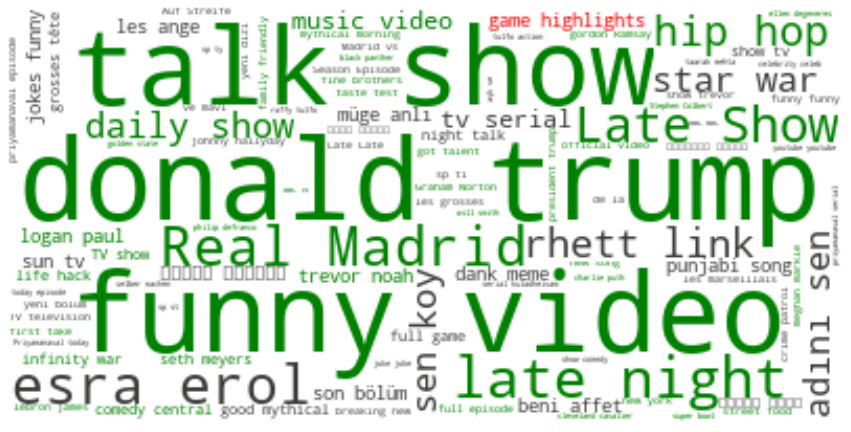

In [59]:
# Create stopword list:
stopwords = set(STOPWORDS)
stopwords.update(['', 'none'])

# Create and generate a word cloud image:
wordcloud = WordCloud(
    stopwords=stopwords,
    max_words=100,
    background_color="white",
    color_func=temp
    #color_func=lambda *args, **kwargs: COLOR_PALETTE['main']
).generate(tags)

# Display the generated image:
fig = plt.figure(figsize=[15,15])
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()
fig.savefig('img/wordcloud_color.jpg')
fig.savefig('img/wordcloud_color.png', format='png', transparent=True)

## Q5: Clickbaitiness

Our first idea was to train a model ourselves by using this github repository: https://github.com/abhishekkrthakur/clickbaits_revisited but they recommend to train on a computer having 64GB of RAM available. Well, we didn't. 

That's why we chose plan B: https://github.com/rahulkapoor90/This-is-Clickbait
This repository is a browser plugin to indicate if certain youtube videos or facebook posts are likely to be clickbait. We are going to use their api. 

We have decided for the US market due to several reasons:
- It's an english speaking country and the clickbaitiness scoring appears to be working for english only.
- Compared with GB, the US have less total views. But these are distributed among twice as many youtube videos. And the more the better.

Remark: This data was crawled from the API. This was performed over the course of one hour in order to comply with a fair usage of their api. Hence, we have uploaded a csv file containing these score to blackboard as well. This file is going to be loaded now instead of running the script. You can find the script in the appendix of this notebook. 

In [60]:
# without clickbait score
df_static.head(1)

,video_id,title,channel_title,publish_time,tags,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,trending_date_min,trending_date_max,trending_date_count,views,likes,dislikes,comment_count,publish_time_hour,title_length,title_tokens,title_contains_channel_title,channel_title_length,tags_tokens,desc_length,desc_tokens
0,Ro6eob0LrCY,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,2017-11-13 17:32:55+00:00,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|""merde",https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidéo la plus réalistiquement haineuse du YouTube Game...,FR,Entertainment,2017-11-14,2017-11-17,4,602481,41538,2908,5321,17,40,8,False,19,6,1412,108


In [61]:
df_clickbait_score = pd.read_csv("00_datamadness_final_clickbait_scores.csv")
df_clickbait_score.head()

,country,video_id,clickbaitiness_score
0,US,VYOjWnS4cMY,28.28
1,US,FlsCjmMhFmw,2.87
2,US,ffxKSjUwKdU,76.81
3,US,zEf423kYfqk,14.41
4,US,7C2z4GqqS5E,91.56


In [62]:
# todo: include function how to get the clickbaitscore, instead of doing this seperately
df_static = df_static.merge(df_clickbait_score, on=['country', 'video_id'], how='left')

# with clickbait score
df_static.head(1)

,video_id,title,channel_title,publish_time,tags,thumbnail_link,comments_disabled,ratings_disabled,video_error_or_removed,description,country,category,trending_date_min,trending_date_max,trending_date_count,views,likes,dislikes,comment_count,publish_time_hour,title_length,title_tokens,title_contains_channel_title,channel_title_length,tags_tokens,desc_length,desc_tokens,clickbaitiness_score
0,Ro6eob0LrCY,Malika LePen : Femme de Gauche - Trailer,Le Raptor Dissident,2017-11-13 17:32:55+00:00,"Raptor""|""Dissident""|""Expliquez""|""moi""|""cette""|""merde",https://i.ytimg.com/vi/Ro6eob0LrCY/default.jpg,False,False,False,Dimanche.\n18h30.\nSoyez présents pour la vidéo la plus réalistiquement haineuse du YouTube Game...,FR,Entertainment,2017-11-14,2017-11-17,4,602481,41538,2908,5321,17,40,8,False,19,6,1412,108,NaN


### highest clickbaitiness scores

In [63]:
q5_columns_of_interest = ['title', 'channel_title', 'views', 'likes', 'dislikes', 'comment_count', 'clickbaitiness_score']


In [64]:
df_static[df_static.country == 'US'][q5_columns_of_interest].sort_values(by='clickbaitiness_score', ascending=False).head(5)


,title,channel_title,views,likes,dislikes,comment_count,clickbaitiness_score
59671,What If You Didn't Have Bones?,Life Noggin,437549,14992,420,2616,99.89
63881,I Got 99 Problems But Being A Girl Ain't One! DIY Girls Hacks and More by Blossom,Blossom,21211851,114989,14808,5264,99.83
60670,9 Weird Things To Do When You Are Bored,Troom Troom,5917100,51231,9165,6613,99.74
59721,10 Ridiculous Tech Gadgets!,Matthias,493348,17150,480,5839,99.74
60237,You're not crazy. Apple is slowing down older iPhones. (Apple Byte),CNET,179723,4763,247,1998,99.74


### lowest clickbaitiness scores

In [65]:
df_static[df_static.country == 'US'][q5_columns_of_interest].sort_values(by='clickbaitiness_score', ascending=True).head(5)

,title,channel_title,views,likes,dislikes,comment_count,clickbaitiness_score
58702,MOTOR SPORT - Cardi B x Migos x Nicki Minaj Dance | Matt Steffanina cover,Matt Steffanina,371401,22490,230,1137,0.09
58479,Inside Keanu Reeves' Custom Motorcycle Shop | WIRED,WIRED,704363,16352,224,841,0.10
60606,North Korea Accidentally Hit One Of Its Own Cities With A Ballistic Missile Last Year | CNBC,CNBC,243553,1472,436,918,0.11
61826,Talkin' Football | JEOPARDY!,Jeopardy!,816594,7290,183,1334,0.11
62840,Reverend Billy Graham's Funeral | NBC News,NBC News,472551,5401,1181,0,0.11


### scores among top viewed videos

In [66]:
df_static[df_static.country == 'US'][q5_columns_of_interest].sort_values(by='views', ascending=False).head(5)

,title,channel_title,views,likes,dislikes,comment_count,clickbaitiness_score
64162,Childish Gambino - This Is America (Official Video),ChildishGambinoVEVO,225211923,5023450,343541,517232,28.28
59439,YouTube Rewind: The Shape of 2017 | #YouTubeRewind,YouTube Spotlight,149376127,3093544,1643059,827755,2.87
63817,Ariana Grande - No Tears Left To Cry,ArianaGrandeVevo,148689896,3094021,129502,242039,76.81
63816,"Becky G, Natti Natasha - Sin Pijama (Official Video)",BeckyGVEVO,139334502,1425496,119798,83941,14.41
64373,BTS (방탄소년단) 'FAKE LOVE' Official MV,ibighit,123010920,5613827,206892,1228655,91.56


**Distribution of the clickbaitiness_score**

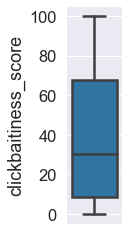

In [67]:
fig, ax = plt.subplots(figsize=(1,4))
ax = sns.boxplot(y="clickbaitiness_score",
                 data=df_static[(df_static.country == 'US')])

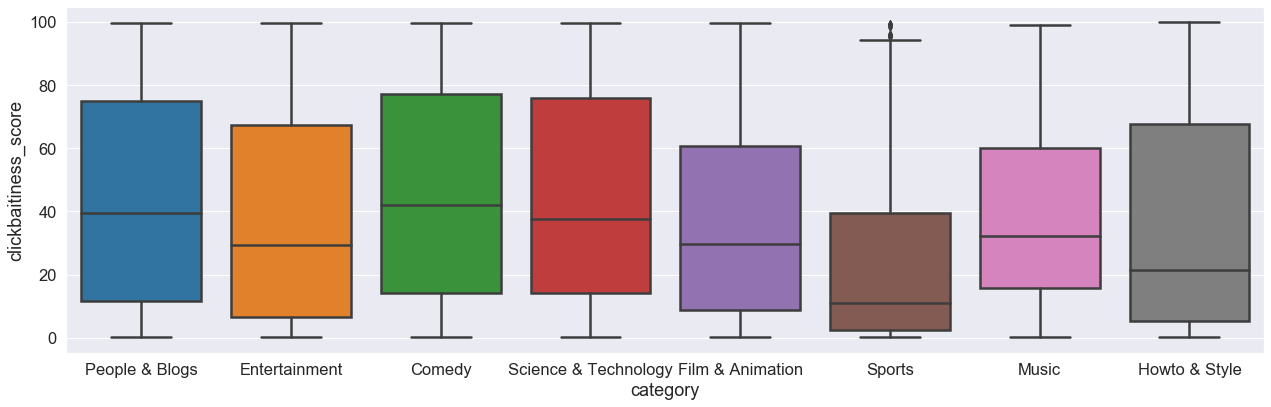

In [68]:
fig = plt.figure(figsize=(18,6))

top_categories = list(df_static[df_static.country == 'US'].groupby('category').views.sum().sort_values(ascending=False).head(8).index)

ax = sns.boxplot(x="category", y="clickbaitiness_score",
                 data=df_static[(df_static.country == 'US') & (df_static.category.isin(top_categories))])
fig.tight_layout()


**Checking, if the views of a video are somehow influenced by the clickbaitiness score**

Therefore, no pattern is visible.

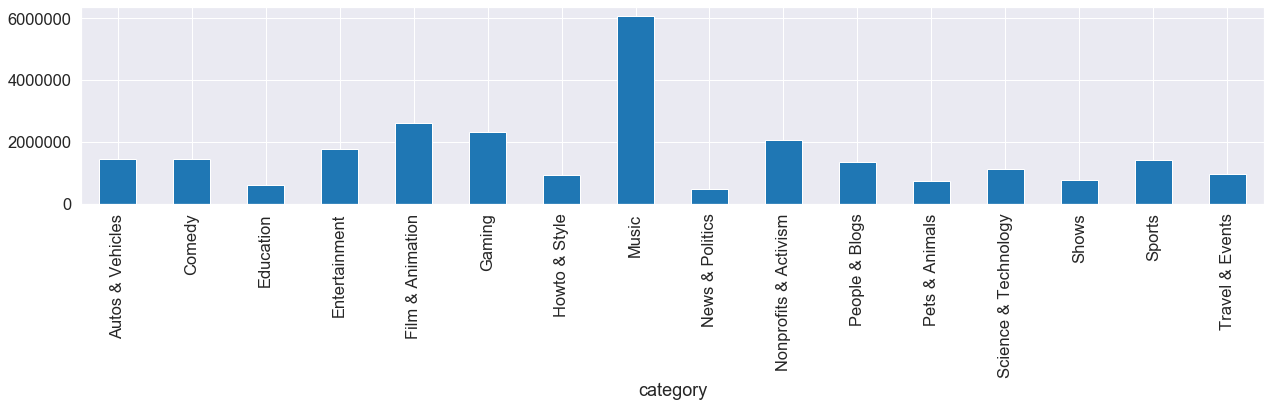

In [69]:
# choosing music as a category to answer this questions, because it hold the most views.
fig, ax = plt.subplots(figsize=(18,6))
df_static[df_static.country == 'US'].groupby('category').views.mean().plot(kind='bar', ax=ax)
fig.tight_layout()

In [70]:
q5_df = df_static[(df_static.country == 'US') & (df_static.category == 'Music')].copy()

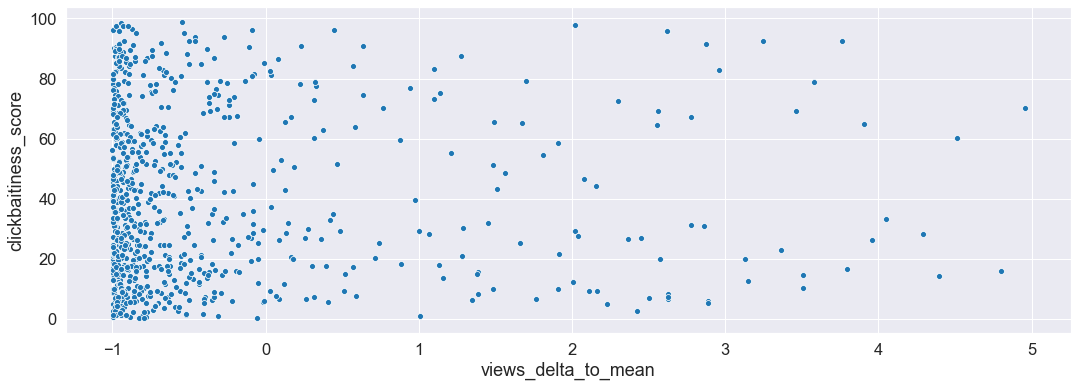

In [71]:
fig, ax = plt.subplots(figsize=(18,6))
q5_df['views_delta_to_mean'] = (q5_df.views - q5_df.views.mean()) / q5_df.views.mean()
sns.scatterplot(x='views_delta_to_mean', y='clickbaitiness_score', data=q5_df[q5_df.views_delta_to_mean < 5][['clickbaitiness_score', 'views_delta_to_mean']])                
                

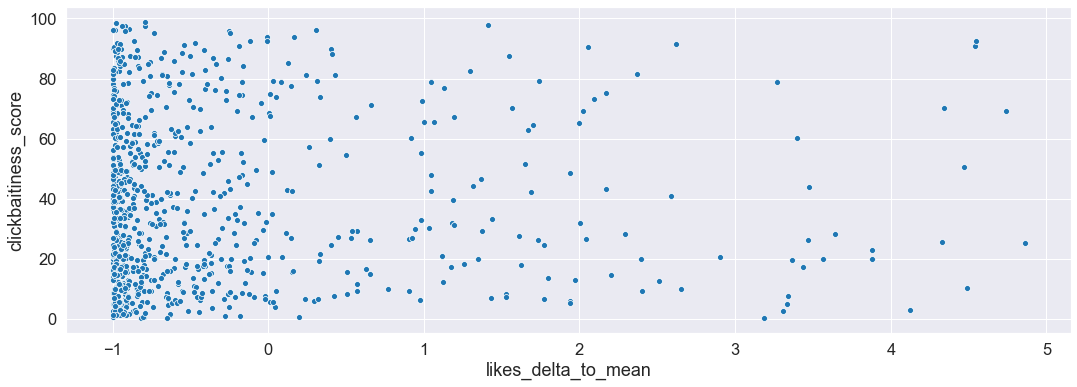

In [72]:
fig, ax = plt.subplots(figsize=(18,6))
q5_df['likes_delta_to_mean'] = (q5_df.likes - q5_df.likes.mean()) / q5_df.likes.mean()
sns.scatterplot(x='likes_delta_to_mean', y='clickbaitiness_score', data=q5_df[q5_df.likes_delta_to_mean < 5][['clickbaitiness_score', 'likes_delta_to_mean']])                
                

### code for requesting the clickbaitiness score for each youtube title

In [73]:
from requests.exceptions import HTTPError
from random import uniform
from time import sleep
from urllib import parse
import requests

CLICKBAITINESS_URL = "https://clickbait-detector.herokuapp.com/detect?headline="


def get_clickbaitiness_score(text):
    # set the headers
    user_agent = "Mozilla/5.0 (Macintosh; Intel Mac OS X 10_13_6) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.149 Safari/537.36"
    headers = {'User-Agent': user_agent}

    # set url
    url = CLICKBAITINESS_URL + parse.quote(text)

    try:
        response = requests.get(url, headers=headers)

        # If the response was successful, no Exception will be raised
        response.raise_for_status()

    except HTTPError as http_err:
        print(f'{text}: HTTP error occurred: {http_err}')
        return None
    except Exception as err:
        print(f'{text}: Other error occurred: {err}')
        return None

    return response.json()['clickbaitiness']


def pause_for_a_bit():

    sleep(round(uniform(0.5, 1.0), 3))


def run_crawler(df, country):
    df_result = df[df.country == country][['country', 'video_id', 'title']].copy()
    df_result['clickbaitiness_score'] = np.nan
    
    for index, row in df_result[df_result.clickbaitiness_score.isna()].iterrows():
        if index > 0 and index % 250 == 0:
            print(f"Have reached row: {index} with title: {row.title}")

        score = get_clickbaitiness_score(row['title'])
        df_result.at[index, 'clickbaitiness_score'] = score
        pause_for_a_bit()
        
    df_result.drop(columns=['title'], inplace=True)
    df_result.to_csv('00_datamadness_final_clickbait_scores.csv', index=False)

# Will not be run now as it takes to much time.
#run_crawler(df,'US') # We have crawler for US data only

# IV. Conclusions



**What did we learn?**  

This dataset showed the performance of trending videos on youtube in the countries France, Great Britain, Canada, US and Germany between the end of 2017 and mid 2018. The earliests date of upload of these videos reached back 12 years. From this dataset we learned, that among the observed countries, Canada and Great Britan had the highest number of views, while France had the lowest.

The total number of days a video was trending ranged between 1 and 38 days, with a majority of these videos staying below 5 days in total. By looking at the publishing time, we sea, that most videos were uploaded during mid-day. But videos published in the morning hours have received more views the average. This is especially true for Great Britain. Reason is, that during these times, all of the music videos trending in GB where published. Due to the fact, that music videos have the most views, there publishing hours happen to be very high in views as well.

The top categories by views are mostly similar across all countries. These include music and entertainment. Besides these, some countries showed a favorit, e.g. sports for France and people&blogs for Germany.

Videos with a title of around 20 characters in length received the most views. And by looking at the individual tags of every video, following ones were most frequently used: donald trump, talk show, funny video, Late Show, Real Madrid.

**What are limitations and future directions?**  
This dataset contained cumulative values only. This made it more challenging to analyse and gather valuable insights. For the next time, we would either find a dataset with values corresponding to the actual trending date only or would need to calculate these.

Regarding clickbait: While we had lots of fun reading the titles and guessing what the clickbaitiness score might be, we haven't found any usefull information and thus have not included it into our video.